# Decision Tree and Random Forest Classifier
### Summary
In this notebook, I experimented with fitting a single decision tree and a random forest classifier to the data. I evaluated models based on their average test set score under stratified 10-fold cross-validation.

My key findings:
* Decision tree
    * Best score was 0.7645.
    * Max depth could be limited to ~15 (down from 37) without much loss. I have a graph (`images/dt_perfomance_vs_max_depth.svg`) to illustrate this.
    * Best criterion was gini.
* Random Forest Classifier
    * Best score was 0.8926.
    * Best size for forest was 1000 trees. Any more than that slowed down training without improving the score. The default was 100.
    * Best value for `max_features` was the default of `sqrt(<total number of features>)`.

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from tabulate import tabulate
import graphviz
avg = lambda l: sum(l) / len(l)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
sentences_arff = arff.loadarff('data.arff')
sentences_df = pd.DataFrame(sentences_arff[0])
sentences_np = sentences_df.to_numpy()
sentences_X = sentences_np[:, :-1]
sentences_y = np.array(list(map(lambda x: x.decode(), sentences_np[:, -1])))

## Decision Tree

In [73]:
## Plot of tree trained on full data set
clf = DecisionTreeClassifier(random_state=0)
clf.fit(sentences_X, sentences_y)
print(f"Depth: {clf.get_depth()}")
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=sentences_df.columns[:-1],
                                class_names=sorted(list(set(sentences_y))),
                                filled=True,
                                max_depth=3)

# Draw graph
graph = graphviz.Source(dot_data, format="svg") 
graph.render("tree-all_data")

Depth: 32


'tree-all_data.svg'

### Performance vs Max Depth

In [5]:
results = []
for max_depth in range(3, 37):
    kf = StratifiedKFold(n_splits=10)
    training_accuracies = []
    test_accuracies = []
    for train, test in kf.split(sentences_X, sentences_y):
        X_train, X_test, y_train, y_test = sentences_X[train], sentences_X[test], sentences_y[train], sentences_y[test]
        model = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
        model.fit(X_train, y_train)
        training_accuracies.append(model.score(X_train, y_train))
        test_accuracies.append(model.score(X_test, y_test))
    results.append([f'max_depth={max_depth}', avg(training_accuracies), avg(test_accuracies)])

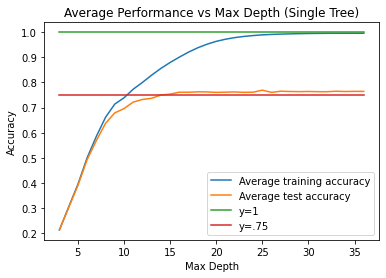

<Figure size 432x288 with 0 Axes>

In [6]:
# print(tabulate(results, headers=['Model parameters', 'Average training accuracy', 'Average test accuracy']))
X = np.arange(3, 37)
training_accuracies = [x[1] for x in results]
test_accuracies = [x[2] for x in results]
ax = plt.axes()
plt.title('Average Performance vs Max Depth (Single Tree)')
ax.plot(X, training_accuracies, label='Average training accuracy')
ax.plot(X, test_accuracies, label='Average test accuracy')
ax.plot(X, [1]*len(X), label='y=1')
ax.plot(X, [.75]*len(X), label='y=.75')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
ax.legend()

plt.show()
plt.savefig(fname='dt_performance_vs_max_depth.svg', format='svg')

### Experimenting

In [45]:
results = []

In [46]:
# K-Fold without stratification
kf = KFold(n_splits=10)
training_accuracies = []
test_accuracies = []
for train, test in kf.split(sentences_X, sentences_y):
    X_train, X_test, y_train, y_test = sentences_X[train], sentences_X[test], sentences_y[train], sentences_y[test]
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)
    training_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))
results.append(['No stratification', avg(training_accuracies), avg(test_accuracies)])

In [47]:
kf = StratifiedKFold(n_splits=10)
training_accuracies = []
test_accuracies = []
for train, test in kf.split(sentences_X, sentences_y):
    X_train, X_test, y_train, y_test = sentences_X[train], sentences_X[test], sentences_y[train], sentences_y[test]
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)
    training_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))
results.append(['Stratification', avg(training_accuracies), avg(test_accuracies)])

In [48]:
kf = StratifiedKFold(n_splits=20)
training_accuracies = []
test_accuracies = []
for train, test in kf.split(sentences_X, sentences_y):
    X_train, X_test, y_train, y_test = sentences_X[train], sentences_X[test], sentences_y[train], sentences_y[test]
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)
    training_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))
results.append(['k=20', avg(training_accuracies), avg(test_accuracies)])

In [49]:
kf = StratifiedKFold(n_splits=10)
for criterion in ['entropy', 'log_loss']:
    training_accuracies = []
    test_accuracies = []
    for train, test in kf.split(sentences_X, sentences_y):
        X_train, X_test, y_train, y_test = sentences_X[train], sentences_X[test], sentences_y[train], sentences_y[test]
        model = DecisionTreeClassifier(random_state=0, criterion=criterion)
        model.fit(X_train, y_train)
        training_accuracies.append(model.score(X_train, y_train))
        test_accuracies.append(model.score(X_test, y_test))
    results.append([f'{criterion=}', avg(training_accuracies), avg(test_accuracies)])

In [50]:
print(tabulate(results))

--------------------  --------  --------
No stratification     0.996091  0.32774
Stratification        0.996     0.764457
k=20                  0.995962  0.76592
criterion='entropy'   0.996     0.742305
criterion='log_loss'  0.996     0.742305
--------------------  --------  --------


Best test set accuracy for a single decision tree: **0.7645** as evaluated by 10-fold cross-validation.

## Random Forest Classifier

### Varying n_estimators

In [51]:
results = []

In [54]:
kf = StratifiedKFold(n_splits=10)
for n_estimators in [1, 10, 20, 50, 100, 200, 300, 400, 1000]:
    print(f"{n_estimators=}\r")
    training_accuracies = []
    test_accuracies = []
    max_depth = -1
    for train, test in kf.split(sentences_X, sentences_y):
        X_train, X_test, y_train, y_test = sentences_X[train], sentences_X[test], sentences_y[train], sentences_y[test]
        model = RandomForestClassifier(random_state=0, n_estimators=n_estimators)
        model.fit(X_train, y_train)
        training_accuracies.append(model.score(X_train, y_train))
        test_accuracies.append(model.score(X_test, y_test))
        max_depth = max(max_depth, max([tree.get_depth() for tree in model.estimators_]))
    results.append([f"{n_estimators} trees", avg(training_accuracies), avg(test_accuracies)])

n_estimators=2000
n_estimators=3000


In [55]:
print(tabulate(results, headers=["Hyperparameters", "Average training accuracy", "Average test accuracy"]))

Hyperparameters      Average training accuracy    Average test accuracy
-----------------  ---------------------------  -----------------------
1 trees                               0.871713                 0.650104
10 trees                              0.994588                 0.833195
20 trees                              0.99591                  0.86447
50 trees                              0.996                    0.884018
100 trees                             0.996                    0.888905
200 trees                             0.996                    0.890371
300 trees                             0.996                    0.891674
400 trees                             0.996                    0.890533
1000 trees                            0.996                    0.892651
2000 trees                            0.996                    0.891185
3000 trees                            0.996                    0.892325


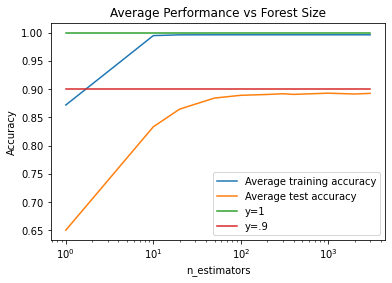

<Figure size 432x288 with 0 Axes>

In [59]:
X = [1, 10, 20, 50, 100, 200, 300, 400, 1000, 2000, 3000]
training_accuracies = [x[1] for x in results]
test_accuracies = [x[2] for x in results]
ax = plt.axes()
plt.title('Average Performance vs Forest Size')
ax.plot(X, training_accuracies, label='Average training accuracy')
ax.plot(X, test_accuracies, label='Average test accuracy')
ax.plot(X, [1]*len(X), label='y=1')
ax.plot(X, [.9]*len(X), label='y=.9')
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.xscale('log')
ax.legend()

plt.show()
plt.savefig(fname='rf_performance_vs_forest_size.svg', format='svg')

Results: best at n_estimators = 1000. Anything beyond that didn't grant any improvement and dramatically slowed down training.

### Varying max_features

In [64]:
cache = dict()

In [74]:
results = []
kf = StratifiedKFold(n_splits=10)
for max_features in [.005, .01, .05, 0.1, 0.2, 0.5, 'sqrt', 0.07, .078]:
    print(f"{max_features=}")
    if max_features in cache:
        print(f"\tFound in cache. Continuing...")
        results.append(cache[max_features])
        continue
    training_accuracies = []
    test_accuracies = []
    for train, test in kf.split(sentences_X, sentences_y):
        X_train, X_test, y_train, y_test = sentences_X[train], sentences_X[test], sentences_y[train], sentences_y[test]
        clf = RandomForestClassifier(random_state=0, max_features=max_features)
        clf.fit(X_train, y_train)
        training_accuracies.append(clf.score(X_train, y_train))
        test_accuracies.append(clf.score(X_test, y_test))
    cache[max_features] = [max_features, avg(training_accuracies), avg(test_accuracies)]
    results.append(cache[max_features])
    
print(tabulate(results, headers=['max_features', 'average training accuracy', 'average test accuracy']))

max_features=0.005
	Found in cache. Continuing...
max_features=0.01
	Found in cache. Continuing...
max_features=0.05
	Found in cache. Continuing...
max_features=0.1
	Found in cache. Continuing...
max_features=0.2
	Found in cache. Continuing...
max_features=0.5
	Found in cache. Continuing...
max_features='sqrt'
	Found in cache. Continuing...
max_features=0.07
	Found in cache. Continuing...
max_features=0.078
	Found in cache. Continuing...
max_features      average training accuracy    average test accuracy
--------------  ---------------------------  -----------------------
0.005                                 0.996                 0.882228
0.01                                  0.996                 0.882228
0.05                                  0.996                 0.884506
0.1                                   0.996                 0.881088
0.2                                   0.996                 0.874246
0.5                                   0.996                 0.864146
sqrt  

Results: best test set accuracy was 0.8926, achieved with `n_estimators=1000` and the default for `max_features`.